# <center>Wasserstein Generative Adversarial Network (WGAN) for NSL-KDD <center/>

Import all necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.stats import norm

from preprocessing import *
from classifiers import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.keras import optimizers

## Define the Critic loss and critic model

In [2]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(data_dim, base_n_neurones,lr = 0.00005):
    model = Sequential(name="critic")
    
    model.add(Dense(base_n_neurones*2, activation='relu',input_dim = data_dim ))
    model.add(Dense(base_n_neurones, activation='relu'))
    model.add(Dense(1))
    
    opt = optimizers.RMSprop(lr=lr)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    
    return model

## Define generator model

In [3]:
def define_generator(data_dim, base_n_neurones,noise_dim):
    
    model = Sequential(name='Generator')
    
    model.add(Dense(base_n_neurones, activation='relu',input_dim = noise_dim ))
    model.add(Dense(base_n_neurones*2, activation='relu'))
    model.add(Dense(base_n_neurones*3, activation='relu'))
    
    model.add(Dense(data_dim))
    
    return model

## Define Combined Model (GAN => D(G(z)))

In [ ]:
def define_gan(generator, critic,lr=0.00005):
    # make critic not trainable
    critic.trainable = False
    model = Sequential(name="combined")
    
    # add generator & critic
    model.add(generator)
    model.add(critic)
    
    # compile model
    opt = optimizers.RMSprop(lr=lr)
    model.compile(loss=wasserstein_loss, optimizer=op)
    
    return model

## Helper methods definitions

In [ ]:
def get_batch(X, batch_size=1):
    batch_ix = np.random.choice(len(X), batch_size, replace=False)
    return X[batch_ix]

def critic_accuracy(model , x , g_z):
    real_label = -np.ones(len(x),dtype=np.int)
    real_pred = [-1 if i < 0.0 else 1 for i in model.predict(x).ravel()]
    acc1 = accuracy_score(real_label,real_pred)
    
    gen_label = np.ones(len(x),dtype=np.int)
    gen_pred = [-1 if i < 0.0 else 1 for i in model.predict(g_z).ravel()]
    acc2 = accuracy_score(gen_label, gen_pred)
    
    print("Critic accuracy on Real : {} , Fake : {}".format(acc1,acc2))
    
def plot_distributions(real_dist,generated_dist):
    kl_values = np.sum(np.where(real_dist != 0, real_dist * np.log(real_dist/generated_dist),0),axis=1)
    top_3 = np.argsort(kl_values)[:3]
    bottom = np.argsort(kl_values)[-3:]

    tot_features = top_3.tolist() + bottom.tolist()
    sns.set(rc={'figure.figsize':(12,8)},font_scale=1.3)
    fig, axes = plt.subplots(nrows=2, ncols=3)
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle('Distributions of Features')

    for ax, feature, name in zip(axes.flatten(), tot_features , tot_features):
        sns.distplot(real_dist[feature], hist = False, kde = True, ax = ax,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = "Real")
        sns.distplot(generated_dist[feature], hist = False, kde = True,ax = ax,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = "Fake")

        ax.set(title=f'Feature #{name}')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Define train procedure 

In [ ]:
def training(dataset, base_n_neurones , rand_dim, n_epochs=10, batch_size=64, n_critic=5):
    
    data_dim = dataset.shape[1]
    clip_value = 0.01
    
    g_model = define_generator(data_dim,base_n_neurones,rand_dim)
    c_model = define_critic(data_dim,base_n_neurones)
    combined = define_gan(g_model,c_model)
    
    bat_per_epo = int(dataset.shape[0] / batch_size)
    tot_epochs = bat_per_epo * n_epochs
    half_batch = int(batch_size / 2)
    
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    
    for i in range(tot_epochs):
        c_model.trainable = True
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real = get_batch(dataset, half_batch)
            
            #Train Critic / discriminator on real
            #c_loss1 = c_model.train_on_batch(X_real, -np.ones(half_batch))
            c_loss1 = c_model.train_on_batch(X_real, -np.random.uniform(low=0.999, high=1.0, size=half_batch))
            c1_tmp.append(c_loss1)
            
            z = np.random.normal(size=(half_batch, rand_dim))
            X_fake = g_model.predict(z)
#             y_fake = np.ones((half_batch, 1))
            
            #Train Critic / discriminator on fake
            #c_loss2 = c_model.train_on_batch(X_fake, np.ones(half_batch))
            c_loss2 = c_model.train_on_batch(X_fake, np.random.uniform(low=0.999, high=1.0, size=half_batch))
            
            c2_tmp.append(c_loss2)
            
            #Clip the weights
            for layer in c_model.layers:
                weights = layer.get_weights()
                weights = [np.clip(weight, -clip_value, clip_value) for weight in weights]
                layer.set_weights(weights)
            
        c_model.trainable = False
        
        # store critic loss
        c1_hist.append(np.mean(c1_tmp))
        c2_hist.append(np.mean(c2_tmp))
        
        z = np.random.normal(size=(batch_size, rand_dim))
        
        # Train generator via the critic's error
        #g_loss = combined.train_on_batch(z, -np.ones(batch_size))
        g_loss = combined.train_on_batch(z, -np.random.uniform(low=0.999, high=1.0, size=batch_size))
        g_hist.append(g_loss)
        
        if i % 10 == 0 :
            print("Epoch : {} , Generator loss {:.6f} ".format(i+1, g_loss))
            z = np.random.normal(size=(len(dataset), rand_dim))
            g_z = g_model.predict(z)
            critic_accuracy(model = c_model, g_z = g_z , x = dataset)
            
            p = norm.pdf(dataset.T)
            q = norm.pdf(g_z.T)
            
            norm_p = p/p.sum(axis=1,keepdims=1)
            norm_q = q/q.sum(axis=1,keepdims=1)
        if i % 100 == 0 :
            plot_distributions(generated_dist=norm_q, real_dist=norm_p)
        
    return dict({"generator_model":g_model,"critic_model":c_model,\
            "combined_model":combined,"generator_loss":g_hist,\
            "disc_loss_generated":c2_hist,"disc_loss_real": c1_hist})


## Load Data

In [ ]:
train,test, label_mapping = get_data(encoding="Label")
x_train,y_train = train.drop("label",axis=1),train.label.values
x_test , y_test =  test.drop("label",axis=1),test.label.values

# scaler = MinMaxScaler(feature_range=(-1, 1))
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

Scaler = StandardScaler()
x_train = Scaler.fit_transform(x_train)
x_test = Scaler.transform(x_test)

att_ind = np.where(train.label == label_mapping["probe"])[0]

dataset = x_train[att_ind]

In [ ]:
label_mapping
# dataset.shape

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}

## Define and declare training parameters

In [ ]:
base_n_neurones = 100

epochs = 1000
batch_size = 64
rand_dim = 32

## Train Models

Instructions for updating:
Colocations handled automatically by placer.
Epoch : 1 , Generator loss -0.000051 
Critic accuracy on Real : 0.13615305422100205 , Fake : 1.0


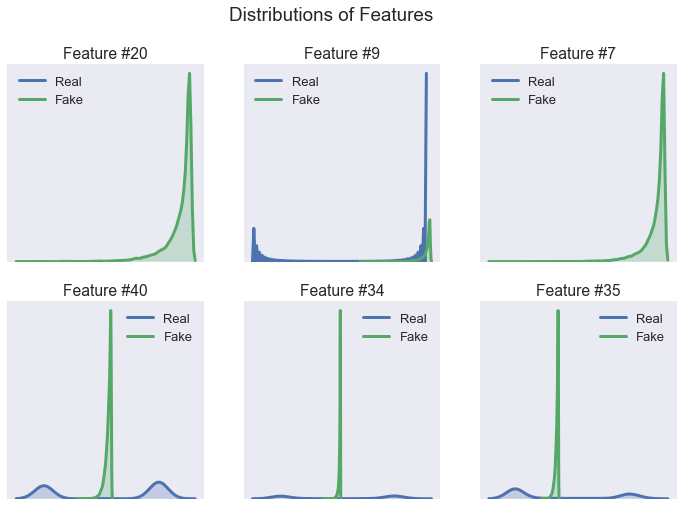

Epoch : 11 , Generator loss -0.000436 
Critic accuracy on Real : 0.010037748798901854 , Fake : 1.0
Epoch : 21 , Generator loss 0.004844 
Critic accuracy on Real : 0.0030885380919698007 , Fake : 0.0
Epoch : 31 , Generator loss 0.001960 
Critic accuracy on Real : 0.00025737817433081676 , Fake : 0.0
Epoch : 41 , Generator loss -0.000710 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 51 , Generator loss -0.001728 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 61 , Generator loss -0.002037 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 71 , Generator loss 0.002113 
Critic accuracy on Real : 0.0 , Fake : 0.0
Epoch : 81 , Generator loss 0.006433 
Critic accuracy on Real : 0.0 , Fake : 0.0
Epoch : 91 , Generator loss 0.004513 
Critic accuracy on Real : 0.0 , Fake : 0.0
Epoch : 101 , Generator loss 0.001823 
Critic accuracy on Real : 0.0 , Fake : 0.0


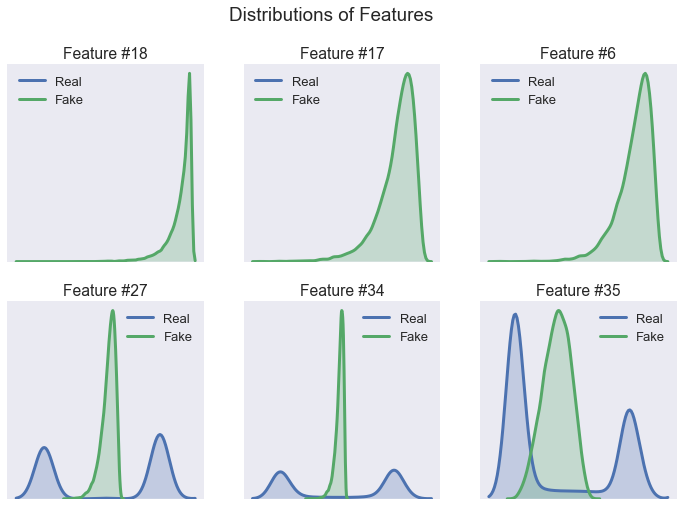

Epoch : 111 , Generator loss 0.000591 
Critic accuracy on Real : 0.0 , Fake : 0.07095058339052848
Epoch : 121 , Generator loss -0.000674 
Critic accuracy on Real : 0.0 , Fake : 0.9996568291008923
Epoch : 131 , Generator loss -0.003268 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 141 , Generator loss -0.008564 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 151 , Generator loss -0.013913 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 161 , Generator loss -0.005047 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 171 , Generator loss 0.032100 
Critic accuracy on Real : 0.11436170212765957 , Fake : 0.0
Epoch : 181 , Generator loss 0.045615 
Critic accuracy on Real : 0.17913520933424845 , Fake : 0.0
Epoch : 191 , Generator loss 0.029639 
Critic accuracy on Real : 0.1911461908030199 , Fake : 0.0
Epoch : 201 , Generator loss 0.014640 
Critic accuracy on Real : 0.10741249142072752 , Fake : 0.0


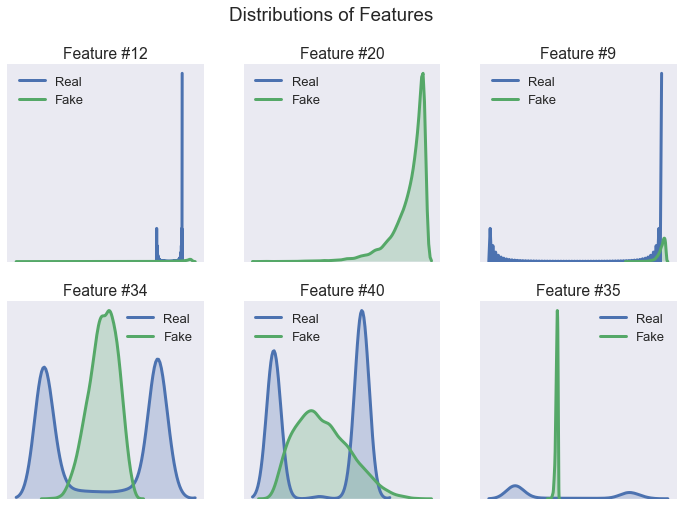

Epoch : 211 , Generator loss -0.000205 
Critic accuracy on Real : 8.579272477693891e-05 , Fake : 0.9528997940974605
Epoch : 221 , Generator loss -0.016895 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 231 , Generator loss -0.040042 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 241 , Generator loss -0.057607 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 251 , Generator loss -0.000843 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 261 , Generator loss 0.127441 
Critic accuracy on Real : 0.39009951956074124 , Fake : 0.0
Epoch : 271 , Generator loss 0.117094 
Critic accuracy on Real : 0.39104323953328757 , Fake : 0.0
Epoch : 281 , Generator loss 0.066715 
Critic accuracy on Real : 0.3875257378174331 , Fake : 0.0
Epoch : 291 , Generator loss 0.032861 
Critic accuracy on Real : 0.38280713795470145 , Fake : 0.0
Epoch : 301 , Generator loss 0.015151 
Critic accuracy on Real : 0.3556108442004118 , Fake : 0.0


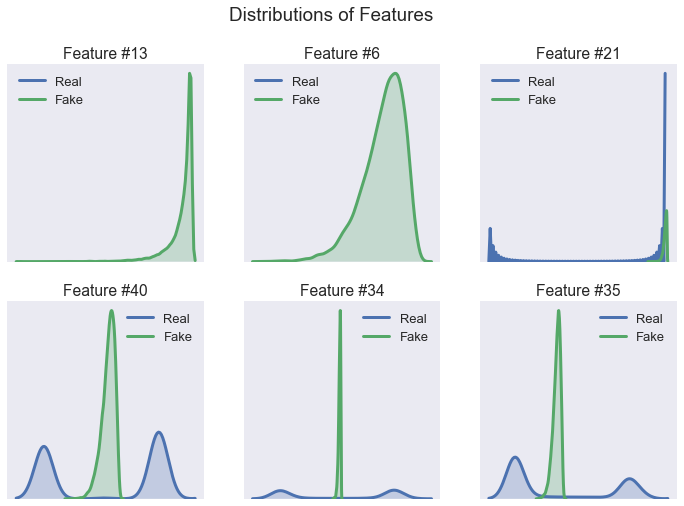

In [ ]:
results = training(dataset,base_n_neurones,rand_dim,n_epochs = epochs,n_critic=2)

## Plot loss

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0,len(results["generator_loss"])), results["generator_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
# results["disc_loss_generated"]

In [ ]:
z = np.random.normal(size=(10000, 32))
# results["combined_model"].predict(z)

In [ ]:
aa = results["generator_model"].predict(z)
r = results["critic_model"].predict(aa)
ww =[ -1.0 if i < 0.0 else 1.0 for i in r ]
accuracy_score(ww,-np.ones(len(aa)))

In [ ]:
X1 = np.random.normal(size = (100,10))
X2 = np.random.normal(size = (100,10))

p = norm.pdf(X1.T)
q = norm.pdf(X2.T)

norm_p = p/p.sum(axis=1,keepdims=1)
norm_q = q/q.sum(axis=1,keepdims=1)

In [ ]:
sns.set(rc={'figure.figsize':(16.7,12.27)},font_scale=1.3)
# sns.set_style("white")
# sns.set_context(font_scale=1.5)
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.subplots_adjust(hspace=0.2)
fig.suptitle('Distributions of Features')

for ax, feature, name in zip(axes.flatten(), [0,1,2,3,4,5], ["a","b","c","D","E","F"]):
    sns.distplot(norm_p[feature], hist = False, kde = True, ax = ax,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "Real")
    sns.distplot(norm_q[feature], hist = False, kde = True,ax = ax,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "Fake")
    #sns.distplot(feature, ax=ax, bins=len(np.unique(data.data.T[0]))//2)
    ax.set(title=name)
    
plt.show()